# NEMO Demo Rebuilt with `pyac`

This notebook reproduces the core ideas from the legacy `nemo-demo.ipynb` using the new `pyac` library API.

Included sections:
- Forming an assembly from repeated stimulus presentations
- Classifying synthetic stimulus classes from assembly overlaps
- Simulating a DFA-style computation (divisibility by 3)

Legacy-only sections (PFA and Markov/trigram language models) are intentionally omitted because they are not in the current `pyac` MVP scope.


In [1]:
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

repo_root = Path.cwd()
pyac_src = repo_root / 'pyac' / 'src'
if str(pyac_src) not in sys.path:
    sys.path.insert(0, str(pyac_src))

from pyac.core.network import Network
from pyac.core.types import AreaSpec, FiberSpec, NetworkSpec, Assembly
from pyac.core.rng import make_rng
from pyac.measures.overlap import assembly_overlap
from pyac.tasks.automata.dfa import DFA
from pyac.tasks.automata.protocol import build_fsm_network, train_fsm, eval_fsm

rng = make_rng(12345)


## 1) Forming an Assembly

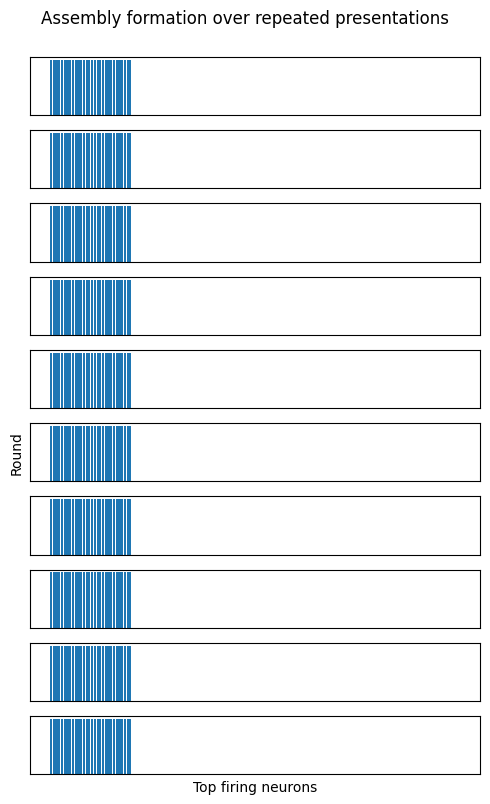

In [2]:
n_inputs = 1000
n_neurons = 1000
cap_size = 30
density = 0.25
plasticity = 0.1
n_rounds = 10

spec = NetworkSpec(
    areas=[
        AreaSpec(name='input', n=n_inputs, k=cap_size, dynamics_type='feedforward'),
        AreaSpec(name='memory', n=n_neurons, k=cap_size, dynamics_type='refracted'),
    ],
    fibers=[FiberSpec(src='input', dst='memory', p_fiber=density)],
    beta=plasticity,
)

net = Network(spec, rng)

stimulus = np.zeros(n_inputs, dtype=np.float64)
stimulus[:cap_size] = 5.0

activations = np.zeros((n_rounds, n_neurons), dtype=np.float64)
for i in range(n_rounds):
    net.activations['input'] = np.array([], dtype=np.int64)
    net.activations['memory'] = np.array([], dtype=np.int64)
    _ = net.step(external_stimuli={'input': stimulus}, plasticity_on=True)
    firing_idx = net.activations['memory']
    if firing_idx.size > 0:
        activations[i, firing_idx] = 1.0

idx = activations.sum(axis=0).argsort()[::-1]
fig, axes = plt.subplots(n_rounds, figsize=(5, 8), sharex=True, sharey=True)
for i in range(n_rounds):
    axes[i].bar(np.arange(5 * cap_size), activations[i, idx[:5 * cap_size]])
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[n_rounds // 2].set_ylabel('Round')
axes[-1].set_xlabel('Top firing neurons')
fig.suptitle('Assembly formation over repeated presentations', y=1.0)
fig.tight_layout()


## 2) Classifying Synthetic Stimulus Classes

Class 0 accuracy: 96.50%
Class 1 accuracy: 62.50%
Class 2 accuracy: 76.00%


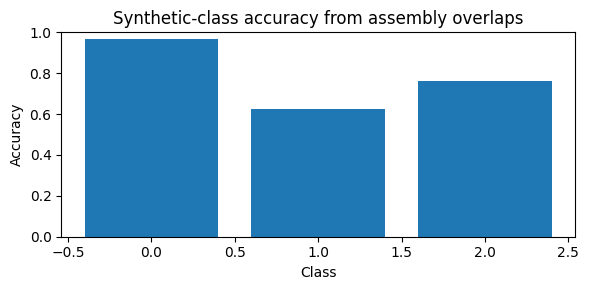

In [3]:
n_classes = 3
n_samples_train = 10
n_samples_test = 200

class_vecs = np.full((n_classes, n_inputs), 0.5 * cap_size / n_inputs, dtype=np.float64)
class_vecs[np.arange(n_classes)[:, None], np.arange(n_classes * cap_size).reshape(n_classes, -1)] = 0.75

samples_train = rng.random((n_classes, n_samples_train, n_inputs)) < class_vecs[:, None, :]
samples_test = rng.random((n_classes, n_samples_test, n_inputs)) < class_vecs[:, None, :]

# Fresh network for class-memory experiment
cls_spec = NetworkSpec(
    areas=[
        AreaSpec(name='input', n=n_inputs, k=cap_size, dynamics_type='feedforward'),
        AreaSpec(name='memory', n=n_neurons, k=cap_size, dynamics_type='refracted'),
    ],
    fibers=[FiberSpec(src='input', dst='memory', p_fiber=density)],
    beta=plasticity,
)
cls_net = Network(cls_spec, rng)

support = {}
for c in range(n_classes):
    for j in range(n_samples_train):
        cls_net.activations['input'] = np.array([], dtype=np.int64)
        cls_net.activations['memory'] = np.array([], dtype=np.int64)
        stim = np.where(samples_train[c, j])[0]
        ext = np.zeros(n_inputs, dtype=np.float64)
        ext[stim] = 5.0
        _ = cls_net.step(external_stimuli={'input': ext}, plasticity_on=True)
    cls_net.normalize('memory')
    support[c] = cls_net.get_assembly('memory')

correct = np.zeros(n_classes, dtype=np.int64)
for c in range(n_classes):
    for j in range(n_samples_test):
        cls_net.activations['input'] = np.array([], dtype=np.int64)
        cls_net.activations['memory'] = np.array([], dtype=np.int64)
        stim = np.where(samples_test[c, j])[0]
        ext = np.zeros(n_inputs, dtype=np.float64)
        ext[stim] = 5.0
        _ = cls_net.step(external_stimuli={'input': ext}, plasticity_on=False)
        pred = cls_net.get_assembly('memory')

        overlaps = np.array([
            assembly_overlap(pred, Assembly(area_name='memory', indices=support[k].indices))
            for k in range(n_classes)
        ])
        if int(overlaps.argmax()) == c:
            correct[c] += 1

accuracy = correct / n_samples_test
for c in range(n_classes):
    print(f'Class {c} accuracy: {accuracy[c]:.2%}')

fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(np.arange(n_classes), accuracy)
ax.set_ylim(0, 1)
ax.set_xlabel('Class')
ax.set_ylabel('Accuracy')
ax.set_title('Synthetic-class accuracy from assembly overlaps')
fig.tight_layout()


## 3) DFA Simulation: Numbers Divisible by 3

In [4]:
states = ('s0', 's1', 's2')
alphabet = tuple(str(d) for d in range(10))
transitions = {}
for s_idx, s in enumerate(states):
    for d in range(10):
        next_idx = (s_idx + d) % 3
        transitions[(s, str(d))] = states[next_idx]

dfa = DFA(
    states=states,
    alphabet=alphabet,
    transitions=transitions,
    initial_state='s0',
    accept_states=frozenset({'s0'}),
)

fsm_rng = make_rng(2026)
fsm_net, area_map = build_fsm_network(
    dfa=dfa,
    n_neurons=500,
    k=30,
    density=0.2,
    plasticity=0.1,
    rng=fsm_rng,
)

assemblies = {}
for s in dfa.states:
    idx = np.sort(fsm_rng.choice(500, size=30, replace=False).astype(np.int64))
    assemblies[s] = Assembly(area_name=area_map['state'], indices=idx)
for sym in dfa.alphabet:
    idx = np.sort(fsm_rng.choice(500, size=30, replace=False).astype(np.int64))
    assemblies[sym] = Assembly(area_name=area_map['symbol'], indices=idx)

train_fsm(
    network=fsm_net,
    dfa=dfa,
    area_mapping=area_map,
    assemblies=assemblies,
    n_presentations=12,
    rng=fsm_rng,
)

def random_digit_string(rng_local, min_len=1, max_len=8):
    L = int(rng_local.integers(min_len, max_len + 1))
    return ''.join(str(int(x)) for x in rng_local.integers(0, 10, size=L))

test_strings = [random_digit_string(fsm_rng) for _ in range(300)]
state_prediction_acc = eval_fsm(
    network=fsm_net,
    dfa=dfa,
    area_mapping=area_map,
    assemblies=assemblies,
    test_strings=test_strings,
    rng=fsm_rng,
)

print(f'State-transition prediction accuracy: {state_prediction_acc:.2%}')
accept_rate = np.mean([int(s) % 3 == 0 for s in test_strings])
print(f'Ground-truth accept fraction in random sample: {accept_rate:.2%}')


State-transition prediction accuracy: 40.33%
Ground-truth accept fraction in random sample: 40.33%


## Notes on Legacy Parity

The original `nemo-demo.ipynb` also included:
- PFA-based sentence generation
- Markov/trigram sequence-estimation demos

Those are intentionally not reproduced here because the current `pyac` MVP focuses on:
- core assembly calculus operations (`project`, `reciprocal_project`, `associate`, `merge`)
- MNIST and DFA task APIs
- IPC and evaluation utilities

If you want, we can add a follow-up notebook that approximates those legacy language-model sections using only current `pyac` primitives.
